# Studienarbeit ADS-04

## 1. Vorbereitung

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
plt.rc("axes.spines", top=False, right=False)
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
from pydot import graph_from_dot_data
import xlrd
import pickle

In [2]:
#sklearn Befehle
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, Normalizer, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.tree import plot_tree
from six import StringIO
from IPython.display import Image

In [3]:
import sklearn
sklearn.__version__

'0.24.2'

In [4]:
np.random.randn(42)
random.seed(42)

## 2. Import

In [5]:
INPUT_DIR = "Input"

In [6]:
superstore_raw = pd.read_excel(os.path.join(INPUT_DIR, "global-superstore.xls"))
superstore_raw.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,2013-02-05,2013-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,2013-11-05,2013-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


Damit die Rohdaten bei der Bearbeitung nicht abgeändert werden, wird der Datensatz kopiert.

In [7]:
copy = superstore_raw.copy()

In [8]:
copy.shape

(51290, 24)

In [9]:
copy["difference"] = copy["Ship Date"] - copy["Order Date"]

In [10]:
copy["Dauer"] = copy["difference"].astype("timedelta64[D]")

In [11]:
copy.shape

(51290, 26)

In [12]:
copy.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,difference,Dauer
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,0 days,0.0
1,26341,IN-2013-77878,2013-02-05,2013-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,2 days,2.0
2,25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,1 days,1.0
3,13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,2 days,2.0
4,47221,SG-2013-4320,2013-11-05,2013-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,1 days,1.0


Damit im späteren Verlauf die Analysen besser durchgeführt werden können, werden die Leerzeichen aus den Spaltennamen entfernt.

In [13]:
copy.rename(columns={'Row ID': 'Row_ID', 'Order Date': 'OrderDate', 'Ship Date': 'ShipDate',
                              'Order ID': 'Order_ID', 'Ship Mode': 'ShipMode', 'Order Priority': 'OrderPriority',
                              'Customer ID': 'Customer_ID', 'Customer Name': 'CustomerName', 'Product ID': 'Product_ID',
                               'Product Name': 'ProductName', 'Shipping Cost': 'ShippingCost', 'Postal Code': 'PostalCode', 'Sub-Category': 'SubCategory'}, inplace=True)

In [14]:
copy.head(5)

,Row_ID,Order_ID,OrderDate,ShipDate,ShipMode,Customer_ID,CustomerName,Segment,City,State,...,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,OrderPriority,difference,Dauer
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,0 days,0.0
1,26341,IN-2013-77878,2013-02-05,2013-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,2 days,2.0
2,25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,1 days,1.0
3,13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,2 days,2.0
4,47221,SG-2013-4320,2013-11-05,2013-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,1 days,1.0


In [15]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Row_ID         51290 non-null  int64          
 1   Order_ID       51290 non-null  object         
 2   OrderDate      51290 non-null  datetime64[ns] 
 3   ShipDate       51290 non-null  datetime64[ns] 
 4   ShipMode       51290 non-null  object         
 5   Customer_ID    51290 non-null  object         
 6   CustomerName   51290 non-null  object         
 7   Segment        51290 non-null  object         
 8   City           51290 non-null  object         
 9   State          51290 non-null  object         
 10  Country        51290 non-null  object         
 11  PostalCode     9994 non-null   float64        
 12  Market         51290 non-null  object         
 13  Region         51290 non-null  object         
 14  Product_ID     51290 non-null  object         
 15  Ca

## 3. train_test_split

In [16]:
train_df, test_df = train_test_split(copy, random_state=42)

In [17]:
train_df.shape

(38467, 26)

In [18]:
test_df.shape

(12823, 26)

In [19]:
train_df.head(5)

,Row_ID,Order_ID,OrderDate,ShipDate,ShipMode,Customer_ID,CustomerName,Segment,City,State,...,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,OrderPriority,difference,Dauer
33162,40087,CA-2012-169572,2012-09-06,2012-09-12,Standard Class,AG-10525,Andy Gerbode,Corporate,Richmond,Virginia,...,Binders,"SlimView Poly Binder, 3/8""",46.620,9,0.0,21.4452,4.210,Medium,6 days,6.0
42206,5477,MX-2014-168298,2014-09-11,2014-09-15,Standard Class,KW-16570,Kelly Williams,Consumer,Apucarana,Parana,...,Labels,"Harbour Creations Color Coded Labels, Laser Pr...",43.000,5,0.0,16.3000,1.771,Medium,4 days,4.0
25603,7232,MX-2012-150616,2012-05-14,2012-05-17,First Class,RS-19765,Roland Schwarz,Corporate,Chinandega,Chinandega,...,Storage,"Fellowes Box, Wire Frame",50.000,4,0.0,21.4400,7.818,High,3 days,3.0
28126,9322,MX-2013-127411,2013-07-30,2013-08-03,Standard Class,RA-19945,Ryan Akin,Consumer,Santo Domingo,Santo Domingo,...,Chairs,"Novimex Rocking Chair, Set of Two",142.592,2,0.2,28.5120,6.405,Medium,4 days,4.0
17208,31736,CA-2014-157252,2014-01-21,2014-01-24,Second Class,CV-12805,Cynthia Voltz,Corporate,New York City,New York,...,Chairs,Global Deluxe Steno Chair,207.846,3,0.1,2.3094,16.050,Medium,3 days,3.0


In [20]:
train_df["OrderPriority"].value_counts()

Medium      22070
High        11660
Critical     2910
Low          1827
Name: OrderPriority, dtype: int64

In [21]:
train_df["ShipMode"].value_counts()

Standard Class    23117
Second Class       7694
First Class        5607
Same Day           2049
Name: ShipMode, dtype: int64

In [22]:
train_df["Region"].value_counts()

Central           8315
South             4975
EMEA              3791
North             3568
Africa            3442
Oceania           2610
West              2447
Southeast Asia    2311
East              2121
North Asia        1755
Central Asia      1552
Caribbean         1285
Canada             295
Name: Region, dtype: int64

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38467 entries, 33162 to 15795
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Row_ID         38467 non-null  int64          
 1   Order_ID       38467 non-null  object         
 2   OrderDate      38467 non-null  datetime64[ns] 
 3   ShipDate       38467 non-null  datetime64[ns] 
 4   ShipMode       38467 non-null  object         
 5   Customer_ID    38467 non-null  object         
 6   CustomerName   38467 non-null  object         
 7   Segment        38467 non-null  object         
 8   City           38467 non-null  object         
 9   State          38467 non-null  object         
 10  Country        38467 non-null  object         
 11  PostalCode     7523 non-null   float64        
 12  Market         38467 non-null  object         
 13  Region         38467 non-null  object         
 14  Product_ID     38467 non-null  object         
 15

## 4. Transform 1 : Dataframe

Als Zielvariable wird die Dauer zwischen Bestelleingang und Versanddatum, die zuvor berechnet wurde festgelegt.

In [24]:
del_cols = ["ShipMode", "Region", "OrderPriority","City", "State", "Country", "Row_ID", "Order_ID", "Customer_ID", "CustomerName", "Segment", "PostalCode", "Market", "Product_ID", "Category", "SubCategory", "ProductName", "Discount", "Profit", "difference", "OrderDate", "ShipDate"]
num_cols = ["Sales", "ShippingCost", "Quantity", "Dauer", "Lieferpriorität", "Versandart", "Herkunftsland"]
float_cols = ["Dauer"]
target = ["Dauer"]

In den nächsten Schritten werden die Objekte der Splaten OrderPriority, ShipMode und Region zu nummerischen Zahlen umgewandelt.

In [25]:
def op_transformer(df):
    
    y =[]
    df2 = df["OrderPriority"]
    df2 = pd.DataFrame(df2)
    for index,row in df2.iterrows():
        if  (row["OrderPriority"] == "Critical"):
            y.append("1")
        elif  (row["OrderPriority"] == "Medium"):
            y.append("3")
        elif  (row["OrderPriority"] == "High"):
            y.append("2")
        else:
            y.append("4")
            
    df = np.asarray(y)
    return df

In [26]:
def ship_mode_transformer(df):
    
    y =[]
    df2 = df["ShipMode"]
    df2 = pd.DataFrame(df2)
    for index,row in df2.iterrows():
        if  (row["ShipMode"] == "Same Day"):
            y.append("1")
        elif  (row["ShipMode"] == "First Class"):
            y.append("2")
        elif  (row["ShipMode"] == "Standard Class"):
            y.append("3")
        else:
            y.append("4")
            
    df = np.asarray(y)
    return df

In [27]:
def region_transformer(df):
    
    y =[]
    df2 = df["Region"]
    df2 = pd.DataFrame(df2)
    for index,row in df2.iterrows():
        if  (row["Region"] == "Central"):
            y.append("1")
        elif  (row["Region"] == "South"):
            y.append("2")
        elif  (row["Region"] == "EMEA"):
            y.append("3")
        elif  (row["Region"] == "North"):
            y.append("4")
        elif  (row["Region"] == "Africa"):
            y.append("5")
        elif  (row["Region"] == "Oceania"):
            y.append("6")
        elif  (row["Region"] == "West"):
            y.append("7")
        elif  (row["Region"] == "Southeast Asia"):
            y.append("8")
        elif  (row["Region"] == "East"):
            y.append("9")
        elif  (row["Region"] == "North Asia"):
            y.append("10")
        elif  (row["Region"] == "Central Asia"):
            y.append("11")
        elif  (row["Region"] == "Caribbean"):
            y.append("12")              
        else:
            y.append("13")
            
    df = np.asarray(y)
    return df

In [28]:
#Die für die Analyse nicht  benötigten Spalten werden mit dieser Funktion aus dem Datensatz gelöscht
def transformer(copy):
    copy = copy.drop(del_cols, axis=1)  

    return copy

In [29]:
copy.head()

,Row_ID,Order_ID,OrderDate,ShipDate,ShipMode,Customer_ID,CustomerName,Segment,City,State,...,SubCategory,ProductName,Sales,Quantity,Discount,Profit,ShippingCost,OrderPriority,difference,Dauer
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,0 days,0.0
1,26341,IN-2013-77878,2013-02-05,2013-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,2 days,2.0
2,25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,1 days,1.0
3,13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,2 days,2.0
4,47221,SG-2013-4320,2013-11-05,2013-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,1 days,1.0


Die zuvor erstellten Funktionen werden nun auf den Datensatz angewendet und direkt in einer neuen Spalte ausgegeben.

In [30]:
train_df["Lieferpriorität"] = op_transformer(train_df)

<ipython-input-30-ca70640ada56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Lieferpriorität"] = op_transformer(train_df)


In [31]:
train_df["Versandart"] = ship_mode_transformer(train_df)

<ipython-input-31-72cd5a897d32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Versandart"] = ship_mode_transformer(train_df)


In [32]:
train_df["Herkunftsland"] = region_transformer(train_df)

<ipython-input-32-ade36d421f32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Herkunftsland"] = region_transformer(train_df)


In [33]:
# perform transformer
train_df = transformer(train_df)

In [34]:
train_df.head()

,Sales,Quantity,ShippingCost,Dauer,Lieferpriorität,Versandart,Herkunftsland
33162,46.620,9,4.210,6.0,3,3,2
42206,43.000,5,1.771,4.0,3,3,2
25603,50.000,4,7.818,3.0,2,2,1
28126,142.592,2,6.405,4.0,3,3,12
17208,207.846,3,16.050,3.0,3,4,9


Die neu generierten Splaten enthalten den Oblekttyp String und müssen daher in den Objekttyp Integer umgewandelt werden:

In [35]:
train_df["Lieferpriorität"] = train_df["Lieferpriorität"].astype(str).astype(int)

In [36]:
train_df["Versandart"] = train_df["Versandart"].astype(str).astype(int)

In [37]:
train_df["Herkunftsland"] = train_df["Herkunftsland"].astype(str).astype(int)

In [38]:
# Überprüfung der Objekttypen
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38467 entries, 33162 to 15795
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sales            38467 non-null  float64
 1   Quantity         38467 non-null  int64  
 2   ShippingCost     38467 non-null  float64
 3   Dauer            38467 non-null  float64
 4   Lieferpriorität  38467 non-null  int32  
 5   Versandart       38467 non-null  int32  
 6   Herkunftsland    38467 non-null  int32  
dtypes: float64(3), int32(3), int64(1)
memory usage: 1.9 MB


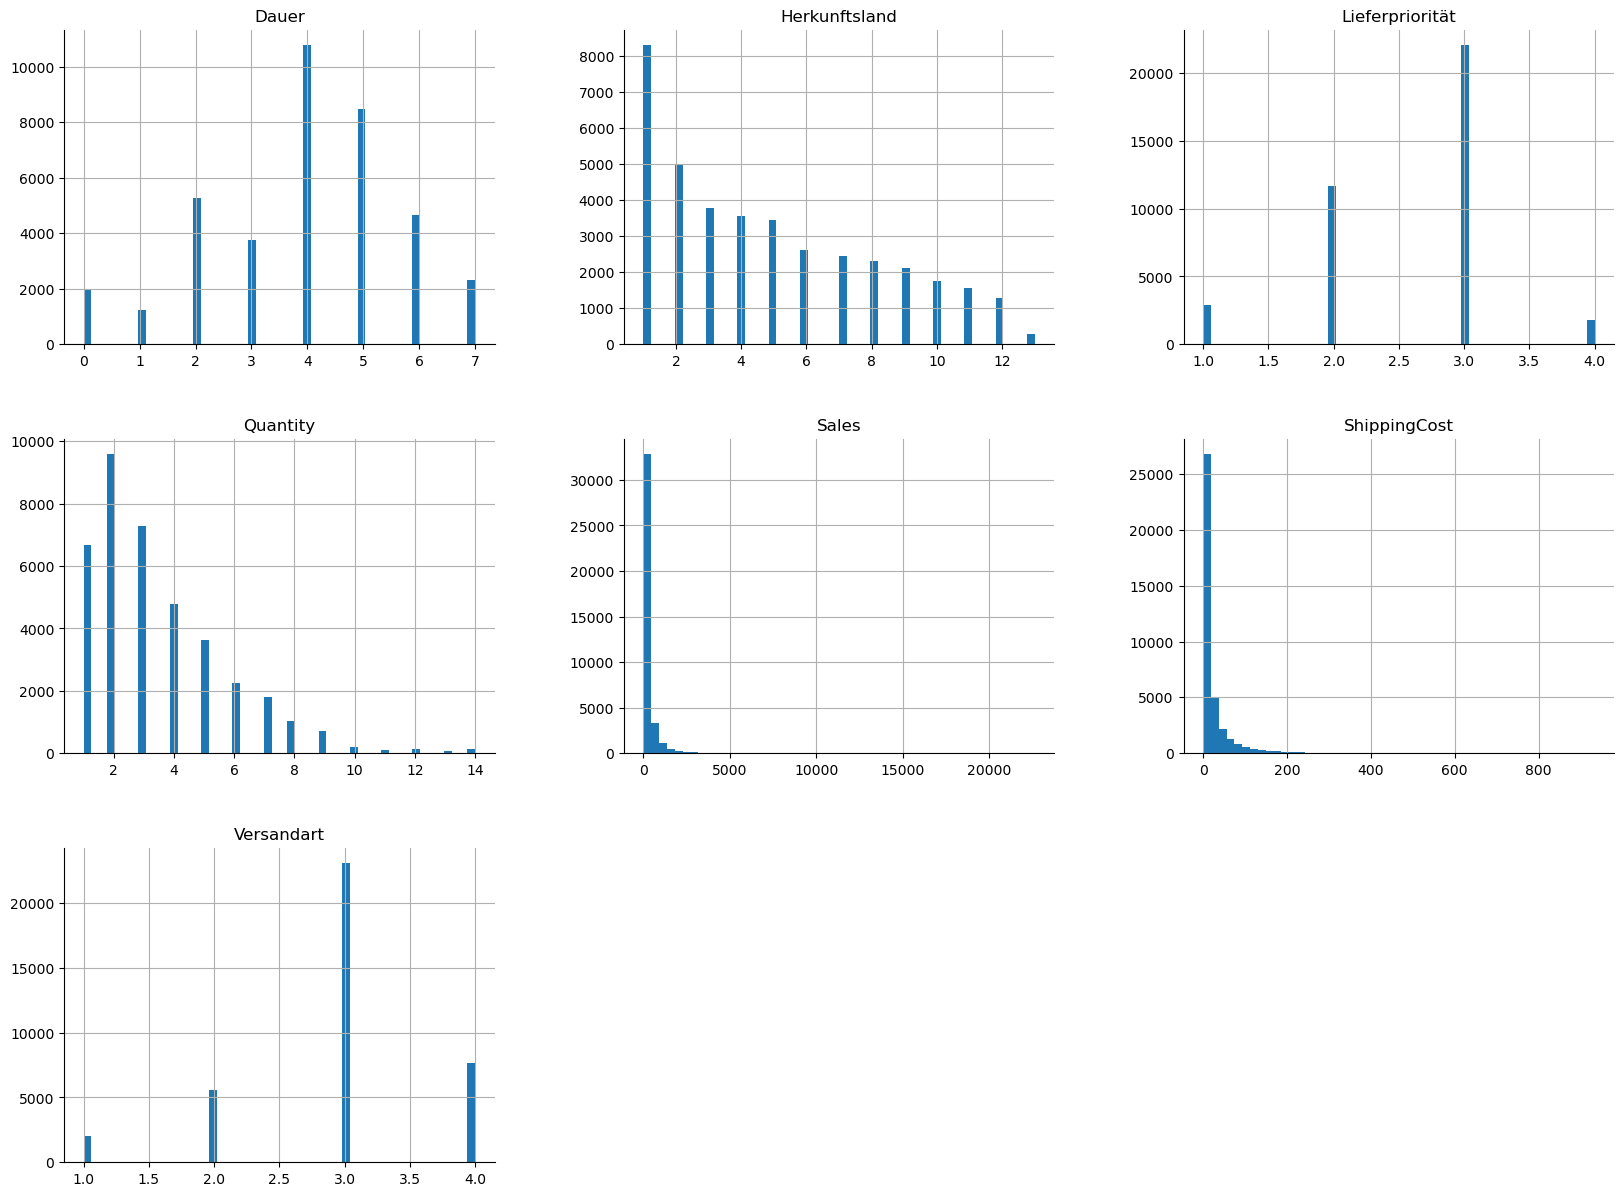

In [39]:
train_df.hist(bins=50, figsize=(20,15))
plt.savefig(os.path.join("output", "Hisogramm Train_df"))
plt.show()

### 4.1 Pairplot

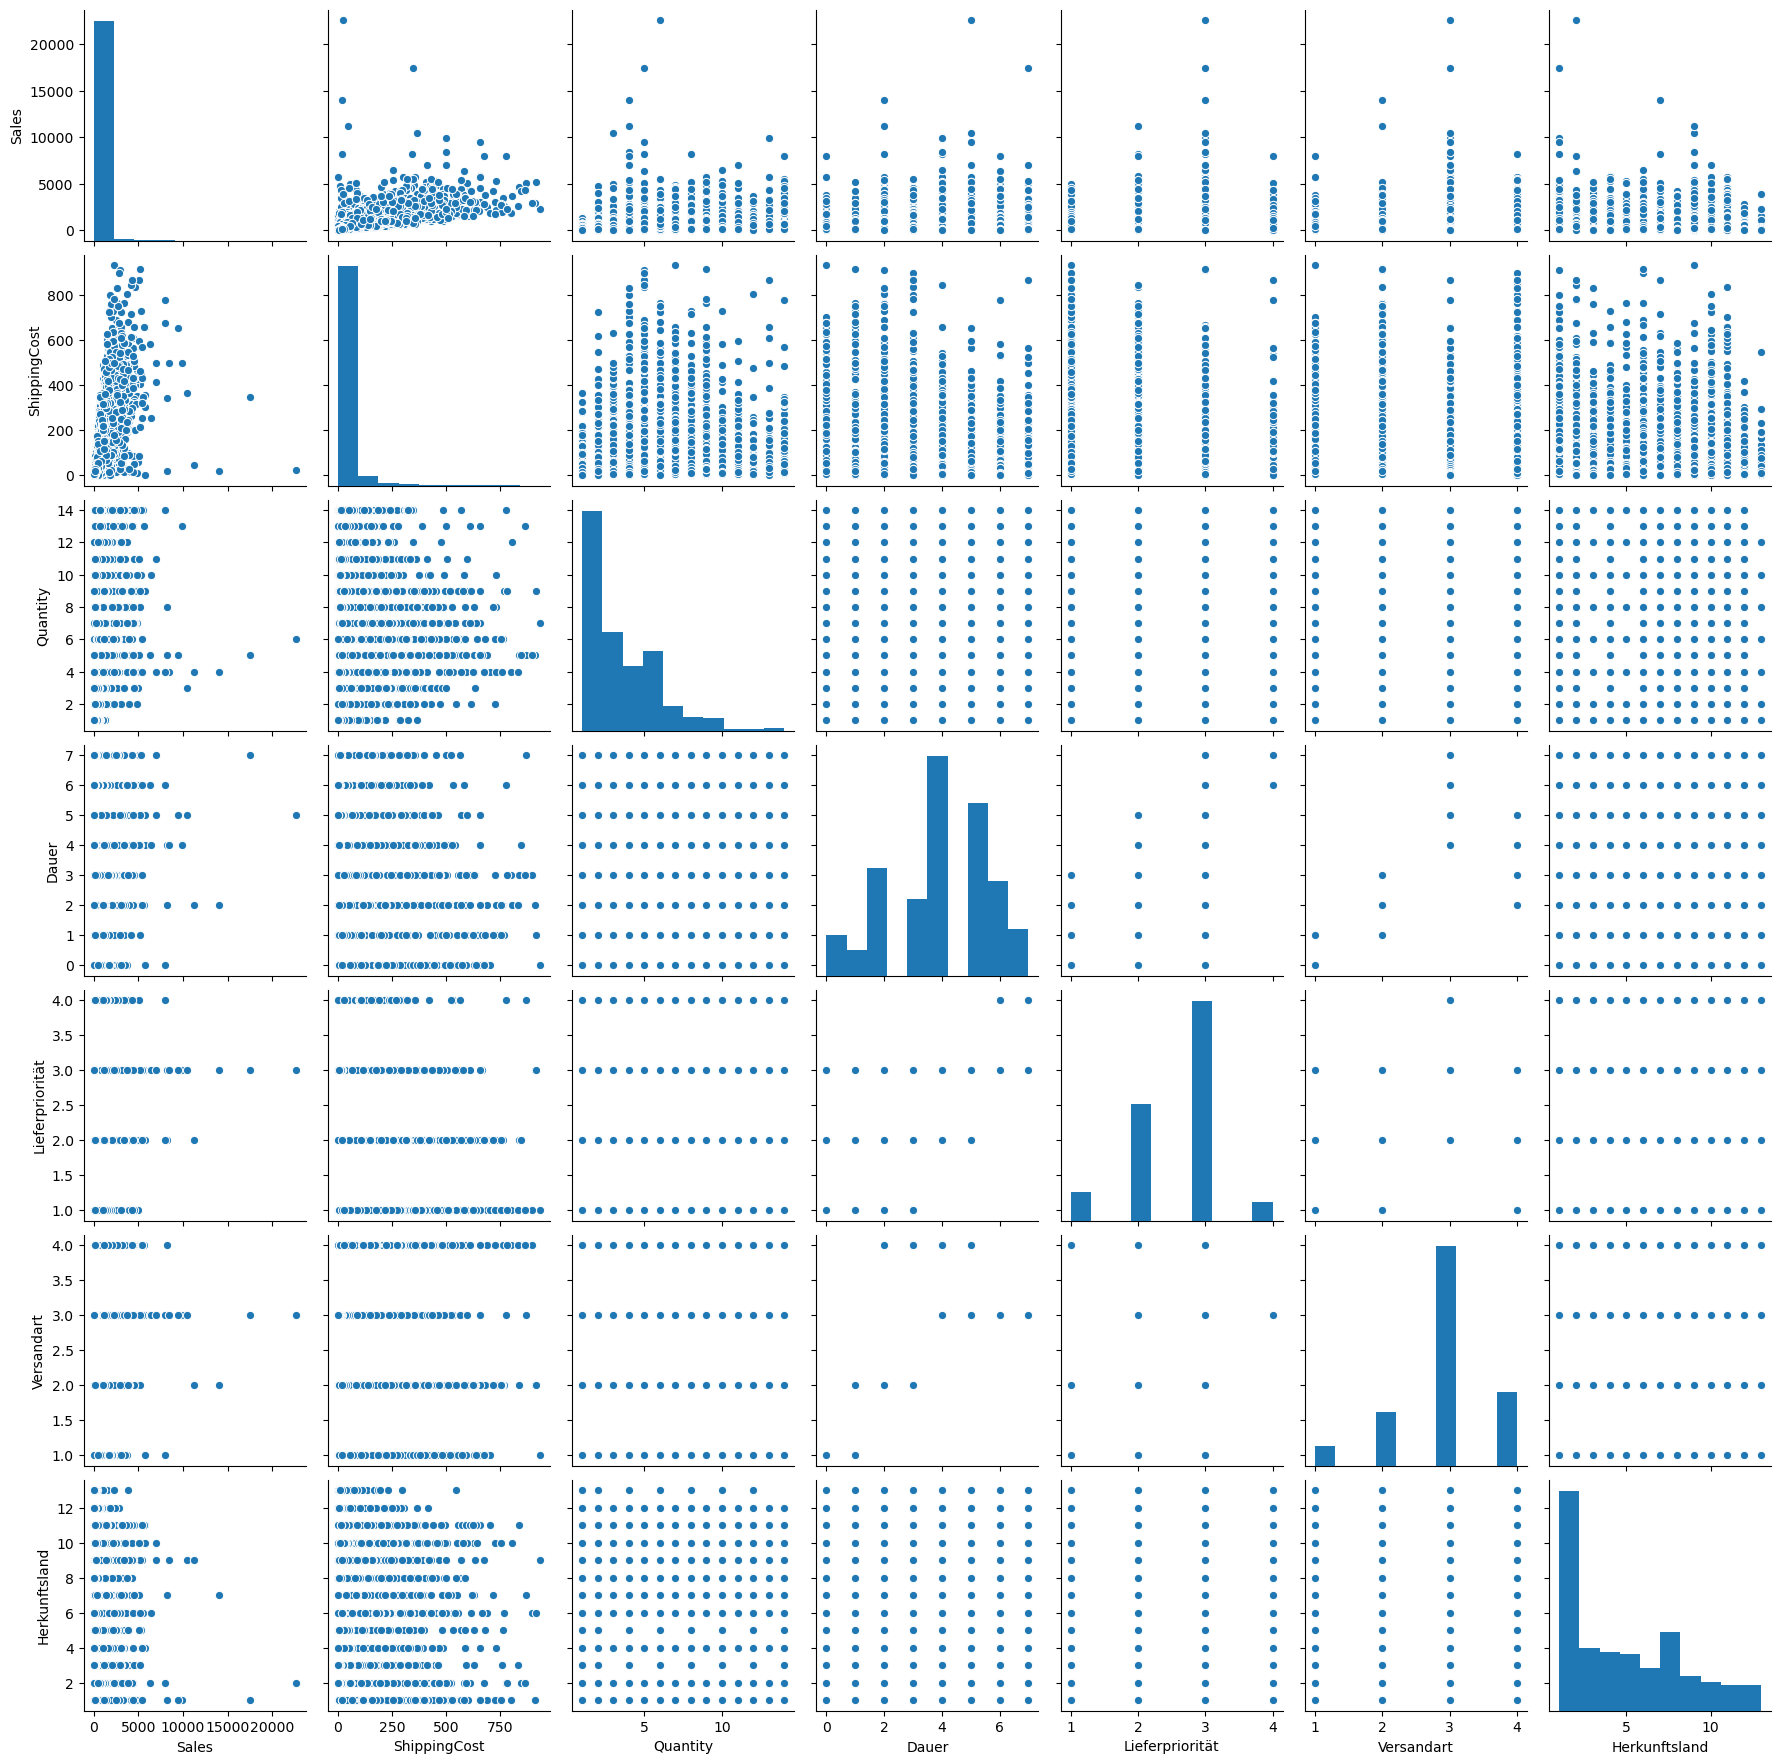

In [40]:
sns.pairplot(train_df[num_cols])
plt.savefig(os.path.join("output", "Pairplot Train_df"))

### 4.2 Subplot 1 : Scatterplot

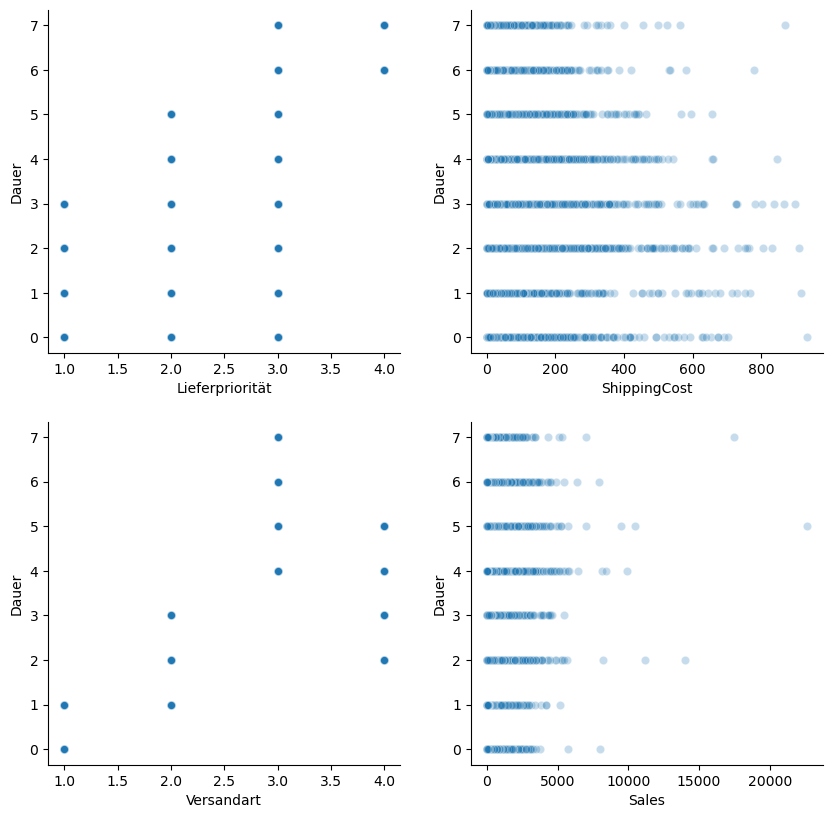

In [41]:
fig, ax = plt.subplots(2, 2, figsize=[10, 10])
sns.scatterplot(x="Lieferpriorität", y="Dauer", data=train_df, alpha=.25, ax=ax[0, 0])
sns.scatterplot(x="ShippingCost", y="Dauer", data=train_df, alpha=.25, ax=ax[0, 1])
sns.scatterplot(x="Versandart", y="Dauer", data=train_df, alpha=.25, ax=ax[1, 0])
sns.scatterplot(x="Sales", y="Dauer", data=train_df, alpha=.25, ax=ax[1, 1])
plt.savefig(os.path.join("output", "Scatterplot Train_df"))

### 4.3 Subplot 2 : Boxplot

In [42]:
#fig, ax = plt.subplots(1, 3, figsize=[15, 5])
#sns.boxplot(x="Lieferpriorität", y="Dauer", data=train_df, color="lightblue", ax=ax[0])
#sns.boxplot(x="Shipping Cost", y="Dauer", data=train_df, color="lightblue", ax=ax[1])
#sns.boxplot(x="Versandart", y="Dauer", data=train_df, color="lightblue", ax=ax[2])

Da der Befehl eine lange Zeit benötigt, bis er die gewünschte Visualisierung anzeigt, wurde dieser zwar ausgeführt, jedoch nicht angezeigt.

### 4.4 Heatmap

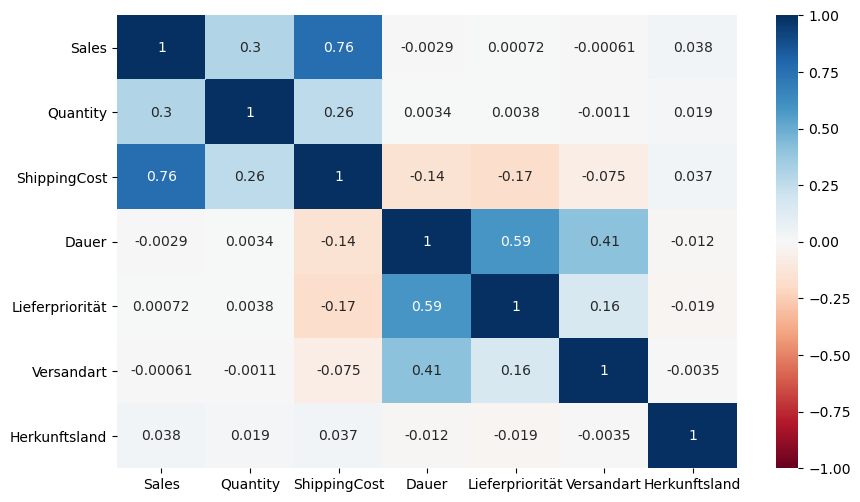

In [43]:
heatmap = sns.heatmap(train_df.corr(), vmin=-1, vmax=1, cmap="RdBu", annot=True)
plt.savefig(os.path.join("output", "Heatmap Train_df"))

## 5. Transform 2 : Pipelines

In [44]:
train_df.head(5)

,Sales,Quantity,ShippingCost,Dauer,Lieferpriorität,Versandart,Herkunftsland
33162,46.620,9,4.210,6.0,3,3,2
42206,43.000,5,1.771,4.0,3,3,2
25603,50.000,4,7.818,3.0,2,2,1
28126,142.592,2,6.405,4.0,3,3,12
17208,207.846,3,16.050,3.0,3,4,9


In [45]:
num_cols

['Sales',
 'ShippingCost',
 'Quantity',
 'Dauer',
 'Lieferpriorität',
 'Versandart',
 'Herkunftsland']

In [46]:
train_df[num_cols].head(2)

,Sales,ShippingCost,Quantity,Dauer,Lieferpriorität,Versandart,Herkunftsland
33162,46.62,4.210,9,6.0,3,3,2
42206,43.00,1.771,5,4.0,3,3,2


In [47]:
num_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
])

In [48]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_cols),
])

In [49]:
X_train = full_pipeline.fit_transform(train_df)
X_train.shape

(38467, 7)

In [50]:
y_train = train_df[target]

## 6. Analyse 1 : Cluster Analyse

In [51]:
n_cluster = 3

In [52]:
km = KMeans(n_clusters=n_cluster, random_state=42)
km.fit(X_train)

KMeans(n_clusters=3, random_state=42)

In [53]:
c1 = km.predict(X_train)
c2 = pd.get_dummies(c1)
cluster_names = ["cluster_%s" % i for i in c2.columns]
c2.columns = cluster_names
c2["cluster"] = c1
df2 = train_df.merge(c2, left_index=True, right_index=True)

### 6.1 Review

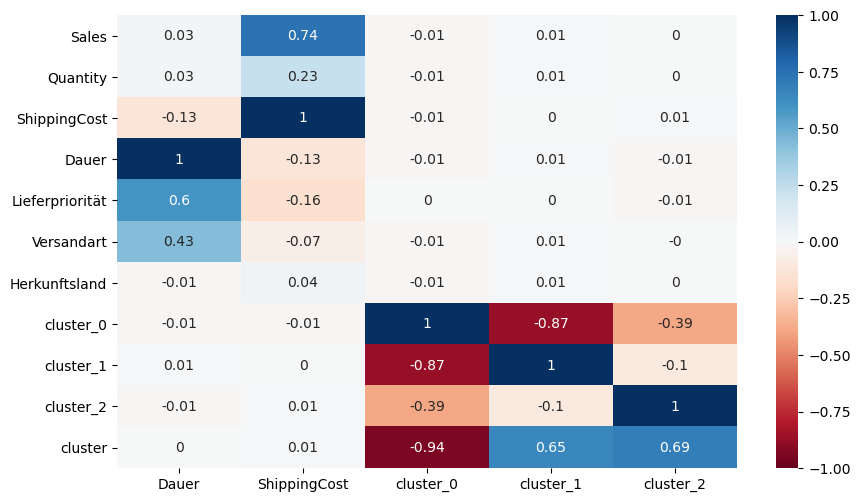

In [54]:
corr = df2.corr().round(2)
corr = corr[["Dauer", "ShippingCost"] + cluster_names]
sns.heatmap(corr, vmin=-1, vmax=1, cmap="RdBu", annot=True)
plt.savefig(os.path.join("output", "Cluster"))

c:\users\niba7\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\niba7\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
c:\users\niba7\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


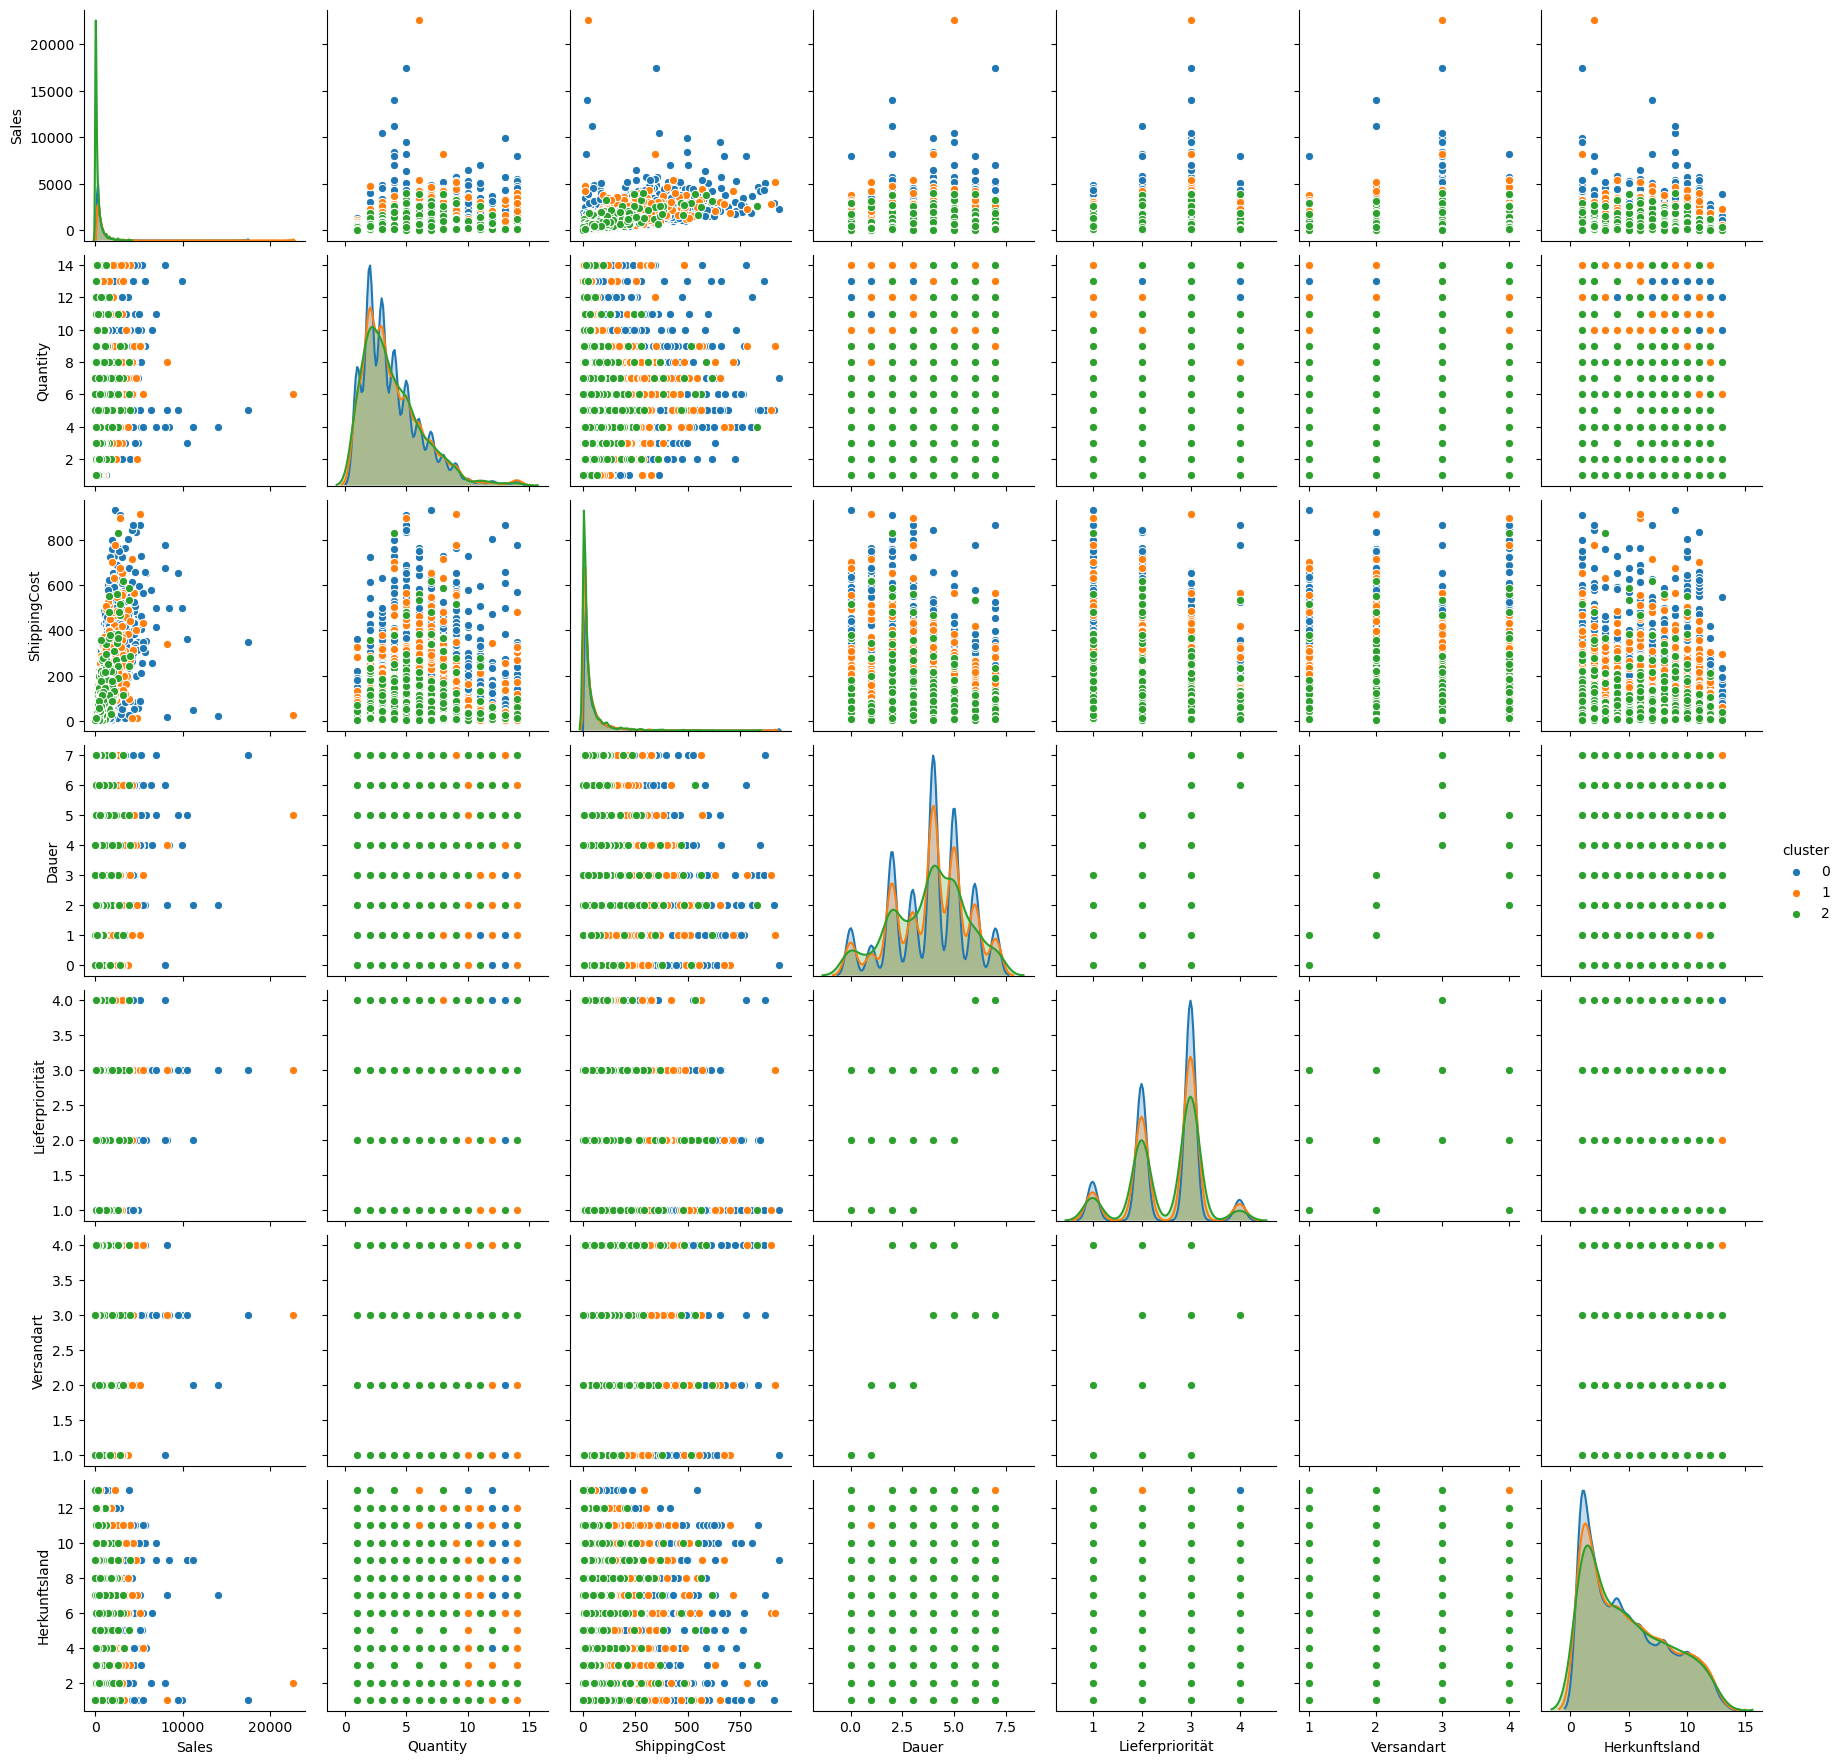

In [55]:
sns.pairplot(data=df2[list(train_df.columns) + ["cluster"]], hue="cluster")

Die Cluster-Analyse zeigt auf, dass der Datensatz in keine passenden Cluster aufgeteilt werden kann und somit die Cluster-Analyse nicht zur Wiederlegung der Hypothese dient.

## 7. Analyse 2 : Entscheidungsbäume

In [56]:
dtclass2 = DecisionTreeClassifier(max_depth=2)
m2 = dtclass2.fit(X_train, y_train)
m2.score(X_train, y_train)

0.7584682975017547

In [57]:
dtclass3 = DecisionTreeClassifier(max_depth=3)
dt3= DecisionTreeClassifier(max_depth=3)
m3 = dtclass3.fit(X_train, y_train)
m3.score(X_train, y_train)

0.916213897626537

In [58]:
dtclass4 = DecisionTreeClassifier(max_depth=4)
m4 = dtclass4.fit(X_train, y_train)
m4.score(X_train, y_train)

0.9674786180362388

In [59]:
features = ["Sales", "ShippingCost", "Quantity", "Dauer", "Lieferpriorität", "Versandart", "Herkunftsland"]
def split_x_y(df, features):
    df = df.dropna()
    y = df["Dauer"]
    X = df.loc[: , features]
    X = pd.get_dummies(X)
    return X, y

In [60]:
X_train_dt, y_train = split_x_y(train_df, features)

In [61]:
print("Shape y:", y_train.shape)
y_train.head()

Shape y: (38467,)


33162    6.0
42206    4.0
25603    3.0
28126    4.0
17208    3.0
Name: Dauer, dtype: float64

In [62]:
dt3.fit(X_train_dt, y_train)

DecisionTreeClassifier(max_depth=3)

In [63]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [64]:
X_train_dt

,Sales,ShippingCost,Quantity,Dauer,Lieferpriorität,Versandart,Herkunftsland
33162,46.62000,4.210,9,6.0,3,3,2
42206,43.00000,1.771,5,4.0,3,3,2
25603,50.00000,7.818,4,3.0,2,2,1
28126,142.59200,6.405,2,4.0,3,3,12
17208,207.84600,16.050,3,3.0,3,4,9
...,...,...,...,...,...,...,...
11284,137.31000,28.640,2,3.0,1,4,4
44732,14.82000,1.280,2,5.0,2,3,4
38158,34.38000,2.690,3,2.0,3,2,8
860,1003.34928,219.533,4,2.0,1,2,4


### 7.1 Review :  Visualize graph

In [65]:
dot_data = StringIO()
export_graphviz(model, out_file=dot_data, feature_names=X_train_dt.columns)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

FileNotFoundError: [WinError 2] "dot" not found in path.

### 7.1.1 Calulate Score

In [66]:
y_train_predict = model.predict(X_train)

In [67]:
pd.crosstab(y_train, y_train_predict)

col_0,2.0,3.0,4.0,5.0,6.0,7.0
Dauer,,,,,,
0.0,1972,0,0,0,0,0
1.0,1251,0,0,0,0,0
2.0,5258,0,0,0,0,0
3.0,0,3760,0,0,0,0
4.0,0,0,10784,0,0,0
5.0,0,0,0,8485,0,0
6.0,0,0,0,0,4649,0
7.0,0,0,0,0,0,2308


In [68]:
vergleich = y_train == y_train_predict
vergleich.mean()

0.916213897626537

In [69]:
model.score(X_train, y_train)

0.916213897626537

### Calculate score for test data

In [70]:
X_test, y_test = split_x_y(train_df, features)

In [71]:
model.score(X_test, y_test)

0.05999948007382951

## 8. Analyse 3 : OLS Regression

In [72]:
model = smf.ols(formula="Dauer ~ Lieferpriorität", data=train_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Dauer   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                 2.071e+04
Date:                Sun, 19 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:14:40   Log-Likelihood:                -67430.
No. Observations:               38467   AIC:                         1.349e+05
Df Residuals:                   38465   BIC:                         1.349e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1632      0.027     

Es besteht ein geringer, linearer Zusammenhang zwischen Dauer und der Variable Lieferpriorität.

In [73]:
model = smf.ols(formula="Dauer ~ Versandart", data=train_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Dauer   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     7821.
Date:                Sun, 19 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:14:44   Log-Likelihood:                -72155.
No. Observations:               38467   AIC:                         1.443e+05
Df Residuals:                   38465   BIC:                         1.443e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1540      0.033     35.152      0.0

Es besteht ein geringer, linearer Zusammenhang zwischen Dauer und der Variable Versandart.

In [74]:
model = smf.ols(formula="Dauer ~ ShippingCost", data=train_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Dauer   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     788.2
Date:                Sun, 19 Dec 2021   Prob (F-statistic):          1.06e-171
Time:                        01:14:45   Log-Likelihood:                -75325.
No. Observations:               38467   AIC:                         1.507e+05
Df Residuals:                   38465   BIC:                         1.507e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.0812      0.010    424.244   

Es besteht kaum ein linearer Zusammenhang zwischen Dauer und der Variable ShippingCost.

In [75]:
model = smf.ols(formula="Dauer ~ Lieferpriorität + Versandart + ShippingCost", data=train_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Dauer   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                 1.056e+04
Date:                Sun, 19 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:14:46   Log-Likelihood:                -64156.
No. Observations:               38467   AIC:                         1.283e+05
Df Residuals:                   38463   BIC:                         1.284e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.6497      0.035    -

Es besteht ein linearer Zusammenhang zwischen Dauer und den Variablen Lieferpriorität + Versandart + ShippingCost, aber nicht besonders hoch.

In [76]:
model = smf.ols(formula="Dauer ~ ShippingCost + np.square(ShippingCost)", data=train_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Dauer   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     453.4
Date:                Sun, 19 Dec 2021   Prob (F-statistic):          2.38e-195
Time:                        01:14:47   Log-Likelihood:                -75267.
No. Observations:               38467   AIC:                         1.505e+05
Df Residuals:                   38464   BIC:                         1.506e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Es besteht kaum ein linearer Zusammenhang zwischen Dauer und den Variable ShippingCost + quadrierter Shipping Cost.

In [77]:
model = smf.ols(formula="Dauer ~ Lieferpriorität + Versandart + ShippingCost + np.square(Lieferpriorität) + np.square(Versandart) + np.square(ShippingCost)", data=train_df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Dauer   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                 1.519e+04
Date:                Sun, 19 Dec 2021   Prob (F-statistic):               0.00
Time:                        01:14:48   Log-Likelihood:                -52353.
No. Observations:               38467   AIC:                         1.047e+05
Df Residuals:                   38460   BIC:                         1.048e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

Es besteht ein linearer Zusammenhang zwischen Dauer und den Variable ShippingCost + Versandart + Lieferpriorität und deren quadrierten Werten.

### 8.1 Review OLS Regression

In [78]:
demo = pd.DataFrame(dict(
    ShippingCost=[(i * 100) + 1000 for i in range(20)],
    Lieferpriorität=[(i * 100) + 1000 for i in range(20)],
    Versandart=[(i * 100) + 1000 for i in range(20)],
    Sales=[(i * 100) + 1000 for i in range(20)]
))

In [79]:
demo

,ShippingCost,Lieferpriorität,Versandart,Sales
0,1000,1000,1000,1000
1,1100,1100,1100,1100
2,1200,1200,1200,1200
3,1300,1300,1300,1300
4,1400,1400,1400,1400
5,1500,1500,1500,1500
6,1600,1600,1600,1600
7,1700,1700,1700,1700
8,1800,1800,1800,1800
9,1900,1900,1900,1900


In [80]:
model1 = smf.ols(formula="Dauer ~Lieferpriorität + Versandart + ShippingCost", data=train_df).fit()
model2 = smf.ols(formula="Dauer ~Lieferpriorität + Versandart + ShippingCost + np.square(Lieferpriorität) + np.square(Versandart) + np.square(ShippingCost)", data=train_df).fit()
predict1 = model1.predict(demo)
predict2 = model2.predict(demo)

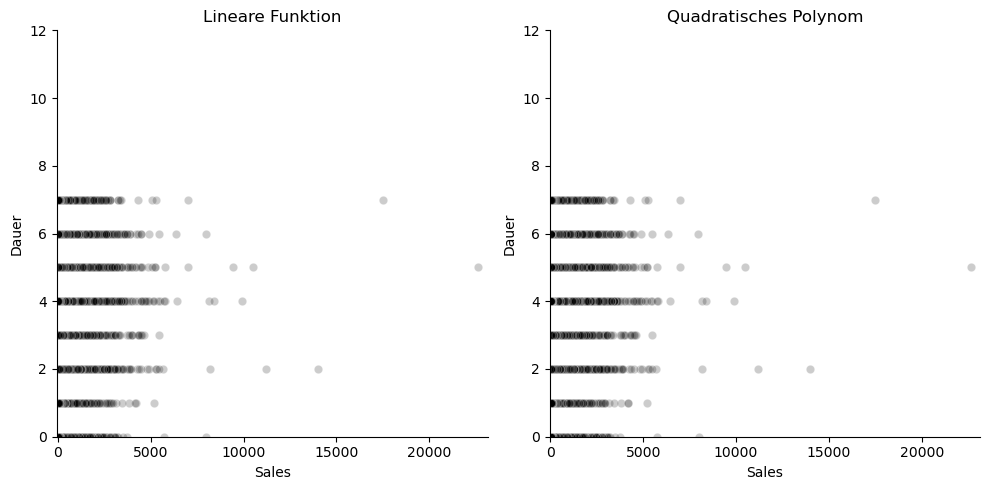

In [81]:
xlim = (train_df["Sales"].min()-50, train_df["Sales"].max()+500)
ylim = (0, train_df["Dauer"].max()+5)
fix, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x="Sales", y="Dauer", data=train_df, color="black", alpha=.2, ax=ax[0])
sns.scatterplot(x="Sales", y="Dauer", data=train_df, color="black", alpha=.2, ax=ax[1])
ax[0].plot(demo["Sales"], predict1, color="blue")
ax[1].plot(demo["Sales"], predict2, color="blue")
for i in [0, 1]:
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
ax[0].set_title("Lineare Funktion")
ax[1].set_title("Quadratisches Polynom")
plt.tight_layout()

-------------------------------------ENDE--------------------------------------------------